# Pipeline for the anomaly detection on the SKAB using LSTM-Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [2]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.LSTM_AE import LSTM_AE
from core.metrics import chp_score
from core.utils import create_sequences, load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [14]:
Xy_traintest_list = load_preprocess_skab()
Xy_traintest_list[0][0]

Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 12:14:36           0.027429           0.040353  0.770310  0.382638   
2020-03-09 12:14:37           0.027269           0.040226  1.096960  0.710565   
2020-03-09 12:14:38           0.027040           0.039773  1.140150  0.054711   
2020-03-09 12:14:39           0.027563           0.040313  1.108680 -0.273216   
2020-03-09 12:14:41           0.026570           0.039566  0.704404  0.382638   
...                                ...                ...       ...       ...   
2020-03-09 12:21:28           0.026785           0.039082  1.051970  0.054711   
2020-03-09 12:21:29           0.027431           0.040196  1.384590  0.382638   
2020-03-09 12:21:30           0.027439           0.041003  1.005890  0.382638   
2020-03-09 12:21:31           0.026955           0.040168  1.142590 -0.273216   
2020-03-09 12:21:32           0.027204           0.040121  1.235270  0.054711   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  
datetime                                                                      
2020-03-09 12:14:36      71.2129       25.0827  219.789              32.0000  
2020-03-09 12:14:37      71.4284       25.0863  233.117              32.0104  
2020-03-09 12:14:38      71.3468       25.0874  234.745              32.0000  
2020-03-09 12:14:39      71.3258       25.0897  205.254              32.0104  
2020-03-09 12:14:41      71.2725       25.0831  212.095              33.0000  
...                          ...           ...      ...                  ...  
2020-03-09 12:21:28      69.4479       25.0272  230.109              32.0112  
2020-03-09 12:21:29      69.1324       25.0281  231.135              32.9892  
2020-03-09 12:21:30      69.4028       25.0294  225.592              32.0000  
2020-03-09 12:21:31      69.3366       25.0208  225.586              32.0112  
2020-03-09 12:21:32      69.5264       25.0286  244.402              32.9892  

[400 rows x 8 columns]

## Method

### Method initialization

In [3]:
# hyperparameters selection
EPOCHS = 100
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 10
Q = 0.99  # quantile for upper control limit (UCL) selection
PARAM = [EPOCHS, BATCH_SIZE, VAL_SPLIT]

In [6]:
model = LSTM_AE(PARAM)


### Method fitting and applying

In [7]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)

    # model fitting
    # history, model = arch(X)
    model.fit(X)

    # results predicting
    residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )
    UCL = residuals.quantile(Q) * 3 / 2

    # results predicting
    X = create_sequences(StSc.transform(X_test), N_STEPS)
    cnn_residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )

    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=X_test.index)
    prediction.iloc[anomalous_data_indices] = 1

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

2024-09-13 17:06:50.783380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-13 17:06:50.783450: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-13 17:06:50.783466: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-13 17:06:50.784522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 17:06:50.784963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


: 

### Results visualization

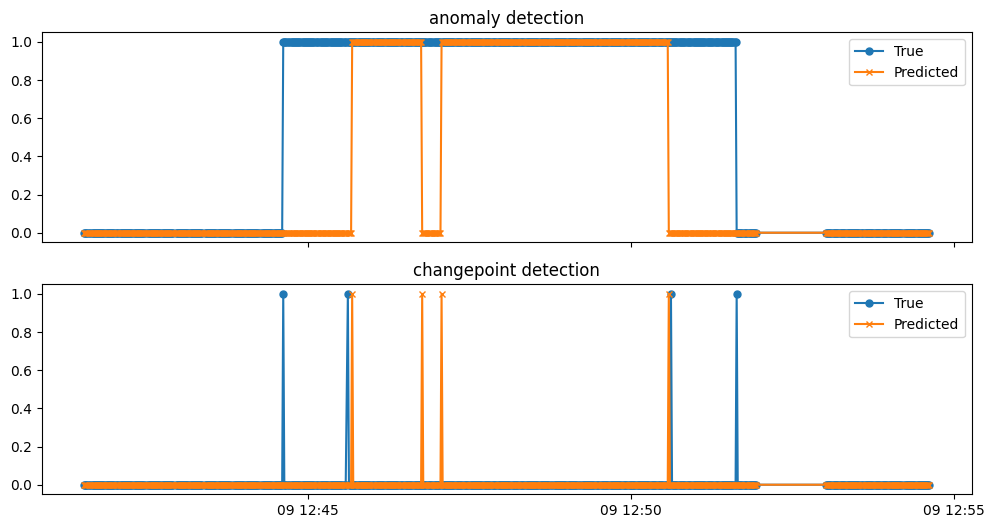

In [ ]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [ ]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-{model.__class__.__name__}.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 29.96 %
Missing Alarm Rate 25.92 %
F1 metric 0.74


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 88
A number of FPs = 69
Average time 0 days 00:00:17


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  23.51
LowFP  -  20.11
LowFN  -  25.91
